<a href="https://colab.research.google.com/github/OsandaDeemantha/Fare-Classification/blob/master/Machine_Learning_Project-2-RF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Load Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fare-Classification/Data/train.csv')
df['label'].replace(to_replace=['correct','incorrect'], value=[1,0],inplace=True)
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,tripid,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare,label
0,189123628,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32,1
1,189125358,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85,1
2,189125719,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64,1
3,189127273,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30,1
4,189128020,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39,1


# **Plot Heat Map**

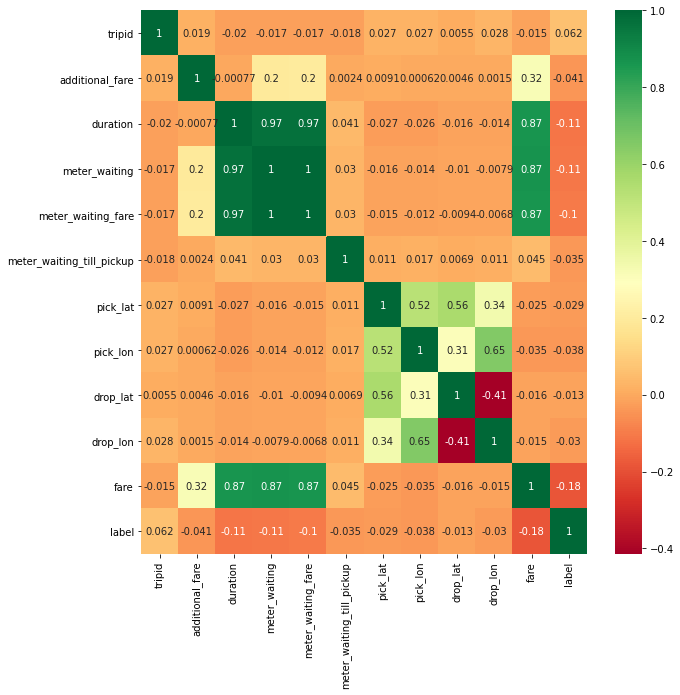

In [3]:
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# **Functions**

In [0]:
def calc_prevalence(y):
 return (sum(y)/len(y))

**Split Date Time**

In [0]:
import datetime
from datetime import timedelta

def extractDataFromDateTimeObj(time):
  datetimeFormat = '%m/%d/%Y %H:%M'
  dateTimeObj = datetime.datetime.strptime(time, datetimeFormat)
  return [dateTimeObj.year, dateTimeObj.month, dateTimeObj.day, dateTimeObj.hour, dateTimeObj.minute, dateTimeObj.weekday(), dateTimeObj.weekday()]

In [0]:
def generateDropTimeData(df):
  df_drop_year = []
  df_drop_month = []
  df_drop_day = []
  df_drop_hour = []
  df_drop_minute = []
  df_drop_weekday = []
  df_drop_weekofyear = []

  for time in df['drop_time']:
    data = extractDataFromDateTimeObj(time)
    df_drop_year.append(data[0])
    df_drop_month.append(data[1])
    df_drop_day.append(data[2])
    df_drop_hour.append(data[3])
    df_drop_minute.append(data[4])
    df_drop_weekday.append(data[5])
    df_drop_weekofyear.append(data[6])

  df['drop_year'] = df_drop_year
  df['drop_month'] = df_drop_month
  df['drop_day'] = df_drop_day
  df['drop_hour'] = df_drop_hour
  df['drop_minute'] = df_drop_minute
  df['drop_weekday'] = df_drop_weekday
  df['drop_weekofyear'] = df_drop_weekofyear

In [0]:
def generatePickupTimeData(df):
  df_pickup_year = []
  df_pickup_month = []
  df_pickup_day = []
  df_pickup_hour = []
  df_pickup_minute = []
  df_pickup_weekday = []
  df_pickup_weekofyear = []

  for time in df['pickup_time']:
    data = extractDataFromDateTimeObj(time)
    df_pickup_year.append(data[0])
    df_pickup_month.append(data[1])
    df_pickup_day.append(data[2])
    df_pickup_hour.append(data[3])
    df_pickup_minute.append(data[4])
    df_pickup_weekday.append(data[5])
    df_pickup_weekofyear.append(data[6])

  df['pickup_year'] = df_pickup_year
  df['pickup_month'] = df_pickup_month
  df['pickup_day'] = df_pickup_day
  df['pickup_hour'] = df_pickup_hour
  df['pickup_minute'] = df_pickup_minute
  df['pickup_weekday'] = df_pickup_weekday
  df['pickup_weekofyear'] = df_pickup_weekofyear

In [0]:
def generatePickupTimestamp(df):
  time = pd.to_datetime(df['pickup_time'])
  df['pickup_timestamp'] = time.values.astype(np.int64) // 10 ** 9

def generateDropTimestamp(df):
  time = pd.to_datetime(df['drop_time'])
  df['drop_timestamp'] = time.values.astype(np.int64) // 10 ** 9

**Calculate Distance**

In [0]:
from geopy.distance import geodesic

def calculateDistance(pick_lat,pick_lon, drop_lat, drop_lon):

  coords_1 = (pick_lat, pick_lon)
  coords_2 = (drop_lat, drop_lon)
  #pick_lat = radians(float(pick_lat))
  #pick_lon = radians(float(pick_lon))
  #drop_lat = radians(float(drop_lat))
  #drop_lon = radians(float(drop_lon))

  if (pick_lon == drop_lon and pick_lat == drop_lat):
    distance = 0.0
    return round(distance, 2)
  else:
    distance = geodesic(coords_1, coords_2).km
    return round(distance, 2)

def calculateDistanceDf(pick_lat_frame,pick_lon_frame, drop_lat_frame, drop_lon_frame):
  distanceList = []
  for i in range(len(drop_lon_frame)):
    pick_lat = pick_lat_frame[i]
    pick_lon = pick_lon_frame[i]
    drop_lat = drop_lat_frame[i]
    drop_lon = drop_lon_frame[i]

    try:
      distance = calculateDistance(pick_lat,pick_lon, drop_lat, drop_lon)
    except:
      print("Error occured! , at", i)

    distanceList.append(distance)
  return distanceList

**Imputation**

In [0]:
import numpy as np
from sklearn.impute import SimpleImputer

def naImpute(features, column_names):
  imp=SimpleImputer(missing_values=np.NaN)
  idf=pd.DataFrame(imp.fit_transform(features))
  idf.columns=features.columns
  idf.index=features.index

  for column_name in column_names:
    idf[column_name].isna().sum()

  
  return idf

**Split Training/ Test Data**

In [0]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# shuffle the samples
# df = df.sample(n = len(df), random_state = 42)
# df = df.reset_index(drop = True)
# valid_df = df.sample(frac = 0.2, random_state = 42)
# train_df = df.drop(valid_df.index)
valid_df = df
train_df = df

In [12]:
print('Valid prevalence(n = %d):%.3f'%(len(valid_df),calc_prevalence(valid_df.label.values)))
print('Train prevalence(n = %d):%.3f'%(len(train_df), calc_prevalence(train_df.label.values)))

Valid prevalence(n = 17176):0.902
Train prevalence(n = 17176):0.902


In [13]:
train_y = train_df.label
list = ['tripid','label']
train_x = train_df.drop(list,axis = 1 )
train_x.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pickup_time,drop_time,pick_lat,pick_lon,drop_lat,drop_lon,fare
0,10.5,834.0,56.0,0.0000,64.0,11/1/2019 0:20,11/1/2019 0:34,6.86252,79.8993,6.90330,79.8783,270.32
1,10.5,791.0,47.0,0.0000,134.0,11/1/2019 0:56,11/1/2019 1:09,6.88589,79.8984,6.91373,79.8923,197.85
2,10.5,1087.0,80.0,0.0000,61.0,11/1/2019 1:08,11/1/2019 1:26,6.90839,79.8651,6.93669,79.9146,301.64
3,10.5,598.0,271.0,15.6638,68.0,11/1/2019 2:27,11/1/2019 2:37,6.92570,79.8895,6.92748,79.8971,82.30
4,NaN,NaN,NaN,NaN,NaN,11/1/2019 3:34,11/1/2019 3:51,6.87441,79.8615,6.84478,79.9290,358.39


Correct:  15495
Incorrect :  1681


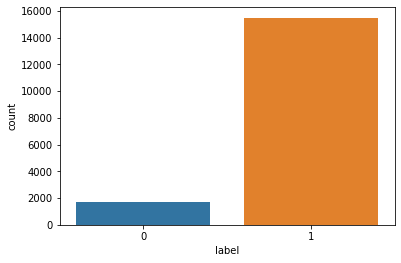

In [14]:
ax = sns.countplot(train_y,label="Count")
C, I = train_y.value_counts()
print('Correct: ',C)
print('Incorrect : ',I)

In [15]:
train_x.describe()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,pick_lat,pick_lon,drop_lat,drop_lon,fare
count,16974.000000,16974.000000,16974.000000,16974.000000,16974.000000,17176.000000,17176.000000,17176.000000,17176.000000,17039.000000
mean,13.719651,1702.858077,629.074231,32.057666,112.466832,6.965499,79.998232389,6.968587,79.997534,312.655466
std,98.975052,8120.160818,8063.260669,465.4835343473,442.054812,0.210760,0.243384,0.378669,0.359648,605.300565
min,0.000000,0.00043000,0.000000,0.000000,0.000000,5.937600,79.819100,5.941860,45.307700,0.000000
25%,10.500000,548.000000,33.000000,0.000000,26.000000,6.865077,79.870400,6.865625,79.870100,125.515000
50%,10.500000,1009.500000,123.000000,0.116600,73.000000,6.914105,79.898600,6.916160,79.899100,211.180000
75%,10.500000,1803.000000,351.000000,14.341800,144.000000,7.043057,79.956600,7.047195,79.960225,366.465000
max,12795.030000,453872.000000,453650.000000,26198.601400,51288.000000,8.051010,81.009600,48.132000,81.009700,26945.990000


# **Data visualization and Pre-processing**

**Functions**

In [0]:
def preProcess(df, features):
  generatePickupTimeData(df)
  generateDropTimeData(df)
  generatePickupTimestamp(df)
  generateDropTimestamp(df)

  df['distance'] = calculateDistanceDf(df['pick_lat'], df['pick_lon'], df['drop_lat'], df['drop_lon'])

  features += ['pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_minute', 'pickup_weekday', 'pickup_weekofyear', 'drop_year', 'drop_month', 'drop_day', 'drop_hour', 'drop_minute', 'drop_weekday', 'drop_weekofyear', 'distance','pickup_timestamp','drop_timestamp']
  Features = df[features]
  Features = naImpute(Features,features)
  return Features

In [0]:
def getX(Features):
    X= preprocessing.StandardScaler().fit(Features).transform(Features)
    return X

**Pre-process Data**

In [18]:
features = ['additional_fare','duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
features = preProcess(train_df, features)
features.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,pickup_year,pickup_month,pickup_day,pickup_hour,pickup_minute,pickup_weekday,pickup_weekofyear,drop_year,drop_month,drop_day,drop_hour,drop_minute,drop_weekday,drop_weekofyear,distance,pickup_timestamp,drop_timestamp
0,10.500000,834.000000,56.000000,0.000000,64.000000,270.32,2019.0,11.0,1.0,0.0,20.0,4.0,4.0,2019.0,11.0,1.0,0.0,34.0,4.0,4.0,5.07,1.572568e+09,1.572568e+09
1,10.500000,791.000000,47.000000,0.000000,134.000000,197.85,2019.0,11.0,1.0,0.0,56.0,4.0,4.0,2019.0,11.0,1.0,1.0,9.0,4.0,4.0,3.15,1.572570e+09,1.572571e+09
2,10.500000,1087.000000,80.000000,0.000000,61.000000,301.64,2019.0,11.0,1.0,1.0,8.0,4.0,4.0,2019.0,11.0,1.0,1.0,26.0,4.0,4.0,6.30,1.572570e+09,1.572572e+09
3,10.500000,598.000000,271.000000,15.663800,68.000000,82.30,2019.0,11.0,1.0,2.0,27.0,4.0,4.0,2019.0,11.0,1.0,2.0,37.0,4.0,4.0,0.86,1.572575e+09,1.572576e+09
4,13.719651,1702.858077,629.074231,32.057666,112.466832,358.39,2019.0,11.0,1.0,3.0,34.0,4.0,4.0,2019.0,11.0,1.0,3.0,51.0,4.0,4.0,8.15,1.572579e+09,1.572580e+09


2754 2572 2523 2501 2450 2436 1940


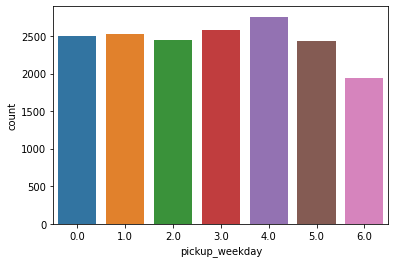

In [19]:
ax = sns.countplot(features.pickup_weekday,label="pickup_weekday")
A, B, C, D, E, F, G = features.pickup_weekday.value_counts()
print(A,B,C,D,E,F,G)

2750 2570 2532 2496 2443 2440 1945


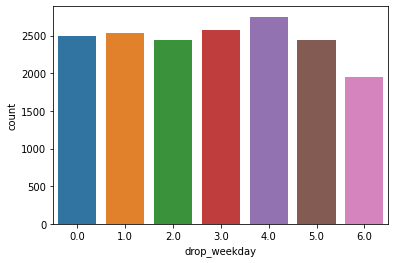

In [20]:
ax = sns.countplot(features.drop_weekday,label="drop_weekday")
A, B, C, D, E, F, G = features.drop_weekday.value_counts()
print(A,B,C,D,E,F,G)

1= 5952 ,11= 5827 ,12= 5397


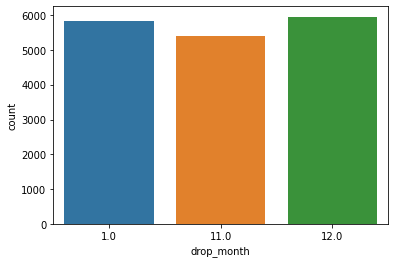

In [21]:
ax = sns.countplot(features.drop_month,label="drop_month")
A, B, C = features.drop_month.value_counts()
print('1=',A,',11=',B,',12=',C)

In [22]:
y = train_df['label'].values
y[0:5]

array([1, 1, 1, 1, 1])

**Normalize Data**

In [23]:
X= getX(features)
X[0:5]

array([[-3.27238746e-02, -1.07638075e-01, -7.14960240e-02,
        -6.92802181e-02, -1.10293576e-01, -7.02239052e-02,
        -7.16359299e-01,  6.09098301e-01, -1.68354365e+00,
        -2.86436081e+00, -5.47836750e-01,  5.61094962e-01,
         5.61094962e-01, -7.16545398e-01,  6.09275746e-01,
        -1.68364402e+00, -2.88449913e+00,  2.63958702e-01,
         5.60211082e-01,  5.60211082e-01,  5.22623770e-03,
        -1.75706685e+00, -1.75755182e+00],
       [-3.27238746e-02, -1.12965110e-01, -7.26188527e-02,
        -6.92802181e-02,  4.90019681e-02, -1.90433433e-01,
        -7.16359299e-01,  6.09098301e-01, -1.68354365e+00,
        -2.86436081e+00,  1.53456998e+00,  5.61094962e-01,
         5.61094962e-01, -7.16545398e-01,  6.09275746e-01,
        -1.68364402e+00, -2.67986929e+00, -1.17456128e+00,
         5.60211082e-01,  5.60211082e-01, -3.94734695e-02,
        -1.75612359e+00, -1.75663471e+00],
       [-3.27238746e-02, -7.62952888e-02, -6.85018140e-02,
        -6.92802181e-02, -1.1

# **K Nearest Neighbor(KNN)**

In [24]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

X_train, y_train=X,y

bestScore=0.0
accList=[]
for k in range(3,15):
    clf_knn = KNeighborsClassifier(n_neighbors=k,algorithm='auto')
    
    scores = cross_val_score(clf_knn, X_train, y_train, cv=10)
    score=scores.mean()
    accList.append(score)
    
    if score > bestScore:
        bestScore=score
        best_clf=clf_knn
        bestK=k
print("Best K is :",bestK,"| Cross validation Accuracy :",bestScore)
clf_knn=best_clf

Best K is : 13 | Cross validation Accuracy : 0.8233740795157377


In [0]:
clf_knn.fit(X_train,y_train)
y_pred=clf_knn.predict(X_train)
trainScores={}

In [26]:
trainScores['KNN-jaccard']=jaccard_similarity_score(y_train, y_pred)
trainScores['KNN-f1-score']=f1_score(y_train, y_pred, average='macro')
trainScores

{'KNN-f1-score': 0.508012998291173, 'KNN-jaccard': 0.9047508150908244}

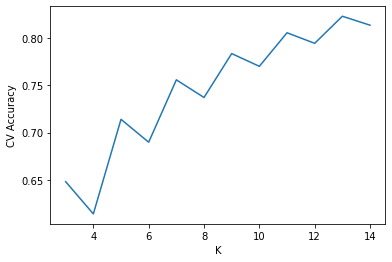

In [27]:
plt.plot(range(3,15),accList)
plt.xlabel('K')
plt.ylabel('CV Accuracy')
plt.show()

# **Logistic Regression**

In [28]:
from sklearn.linear_model import LogisticRegression

clf_log = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')
clf_log.fit(X_train, y_train)

y_pred=clf_log.predict(X_train)
y_proba=clf_log.predict_proba(X_train)
testy=y.astype(float)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
trainScores['LogReg-jaccard']=jaccard_similarity_score(y_train, y_pred)
trainScores['LogReg-f1-score']=f1_score(y_train, y_pred, average='macro')  
trainScores['LogReg-logLoss']=log_loss(y_train, y_proba)

In [30]:
trainScores

{'KNN-f1-score': 0.508012998291173,
 'KNN-jaccard': 0.9047508150908244,
 'LogReg-f1-score': 0.5834926812851827,
 'LogReg-jaccard': 0.911096879366558,
 'LogReg-logLoss': 0.27891634124329034}

# **Random Forest**

In [31]:
from sklearn.ensemble import RandomForestClassifier

clf_rf=RandomForestClassifier(max_depth = 9, n_estimators=100, random_state = 42)
clf_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=9, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [0]:
y_train_pred = clf_rf.predict_proba(X_train)[:,1]
#y_valid_pred = clf_rf.predict_proba(X_valid)[:,1]

In [0]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score

def calc_specificity(y_actual, y_pred, thresh):
 # calculates specificity
 return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)
def print_report(y_actual, y_pred, thresh):
 
 auc = roc_auc_score(y_actual, y_pred)
 accuracy = accuracy_score(y_actual, (y_pred > thresh))
 recall = recall_score(y_actual, (y_pred > thresh))
 precision = precision_score(y_actual, (y_pred > thresh))
 specificity = calc_specificity(y_actual, y_pred, thresh)
 print('AUC:%.3f'%auc)
 print('accuracy:%.3f'%accuracy)
 print('recall:%.3f'%recall)
 print('precision:%.3f'%precision)
 print('specificity:%.3f'%specificity)
 print('prevalence:%.3f'%calc_prevalence(y_actual))
 print(' ')
 return auc, accuracy, recall, precision, specificity

In [34]:
print_report(y_train, y_train_pred, 0.201)

AUC:0.941
accuracy:0.913
recall:1.000
precision:0.912
specificity:0.112
prevalence:0.902
 


(0.9414648927260412,
 0.9131346064275734,
 1.0,
 0.9121681285689056,
 0.1124330755502677)

# **Model Evaluation using Test set**

In [0]:
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [0]:
testScores={}

In [37]:
knn_pred=clf_knn.predict(X_test)
testScores['KNN-jaccard']=jaccard_similarity_score(y_test, knn_pred)
testScores['KNN-f1-score']=f1_score(y_test, knn_pred, average='weighted')

NameError: ignored

In [0]:
log_pred=clf_log.predict(X_test)
proba=clf_log.predict_proba(X_test)
testScores['LogReg-jaccard']=jaccard_similarity_score(y_test, log_pred)
testScores['LogReg-f1-score']=f1_score(y_test, log_pred, average='macro')  
testScores['LogReg-logLoss']=log_loss(y_test, proba)

In [0]:
testScores

# **Prediction**

In [0]:
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fare-Classification/Data/test.csv')
features_test = ['additional_fare','duration', 'meter_waiting', 'meter_waiting_fare', 'meter_waiting_till_pickup', 'fare']
df_test.head()

In [0]:
features_for_test = preProcess(df_test, features_test)
X_pred = getX(features_for_test)
features_for_test.head()

In [0]:
y_pred_for_test = clf_rf.predict(X_pred)

In [0]:
y_pred_for_test

In [0]:
import csv

with open('/content/drive/My Drive/Colab Notebooks/Fare-Classification/Data/RF.csv', mode='w') as submission_file:
    submission_writer = csv.writer(submission_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    submission_writer.writerow(['tripid','prediction'])
    for i in range(len(y_pred_for_test)):
      submission_writer.writerow([df_test['tripid'][i],y_pred_for_test[i]])